### These cells modify the plots of the SHAP values to have better colours and be saved as pdf

In [9]:
def summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type="dot",
                 color=None, axis_color="#333333", title=None, alpha=1, show=True, pdf='_', sort=True,
                 color_bar=True, auto_size_plot=True, layered_violin_max_num_bins=20, class_names=None):
    """Create a SHAP summary plot, colored by feature values when they are provided.
    Parameters
    ----------
    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features)
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    feature_names : list
        Names of the features (length # features)
    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)
    plot_type : "dot" (default) or "violin"
        What type of summary plot to produce
    """

    multi_class = False
    if str(type(shap_values)).endswith("list'>"):
        multi_class = True
        plot_type = "bar" # only type supported for now
    else:
        assert len(shap_values.shape) != 1, "Summary plots need a matrix of shap_values, not a vector."

    # default color:
    if color is None:
        color = "coolwarm" if plot_type == 'layered_violin' else "#1E88E5" #"#ff0052"

    # convert from a DataFrame or other types
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    elif str(type(features)) == "<class 'list'>":
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    num_features = (shap_values[0].shape[1] if multi_class else shap_values.shape[1]) - 1

    if feature_names is None:
        feature_names = [labels['FEATURE'] % str(i) for i in range(num_features)]

    # plotting SHAP interaction values
    if not multi_class and len(shap_values.shape) == 3:
        if max_display is None:
            max_display = 7
        else:
            max_display = min(len(feature_names), max_display)

        sort_inds = np.argsort(-np.abs(shap_values[:, :-1, :-1].sum(1)).sum(0))

        # get plotting limits
        delta = 1.0 / (shap_values.shape[1] ** 2)
        slow = np.nanpercentile(shap_values, delta)
        shigh = np.nanpercentile(shap_values, 100 - delta)
        v = max(abs(slow), abs(shigh))
        slow = -v
        shigh = v

        plt.figure(figsize=(1.5 * max_display + 1, 0.8 * max_display + 1))
        plt.subplot(1, max_display, 1)
        proj_shap_values = shap_values[:, sort_inds[0], np.hstack((sort_inds, len(sort_inds)))]
        proj_shap_values[:, 1:] *= 2  # because off diag effects are split in half
        summary_plot(
            proj_shap_values, features[:, sort_inds],
            feature_names=feature_names[sort_inds],
            sort=False, show=False, color_bar=False,
            auto_size_plot=False,
            max_display=max_display
        )
        plt.xlim((slow, shigh))
        plt.xlabel("")
        title_length_limit = 11
        plt.title(shorten_text(feature_names[sort_inds[0]], title_length_limit))
        for i in range(1, min(len(sort_inds), max_display)):
            ind = sort_inds[i]
            plt.subplot(1, max_display, i + 1)
            proj_shap_values = shap_values[:, ind, np.hstack((sort_inds, len(sort_inds)))]
            proj_shap_values *= 2
            proj_shap_values[:, i] /= 2  # because only off diag effects are split in half
            summary_plot(
                proj_shap_values, features[:, sort_inds],
                sort=False,
                feature_names=["" for i in range(features.shape[1])],
                show=False,
                color_bar=False,
                auto_size_plot=False,
                max_display=max_display
            )
            plt.xlim((slow, shigh))
            plt.xlabel("")
            if i == max_display // 2:
                plt.xlabel(labels['INTERACTION_VALUE'])
            plt.title(shorten_text(feature_names[ind], title_length_limit))
        plt.tight_layout(pad=0, w_pad=0, h_pad=0.0)
        plt.subplots_adjust(hspace=0, wspace=0.1)
        if show:
            plt.show()
        return
    
        if max_display is None:
            max_display = 20

    if sort:
        # order features by the sum of their effect magnitudes
        if multi_class:
            feature_order = np.argsort(np.sum(np.mean(np.abs(shap_values), axis=0), axis=0)[:-1])
        else:
            feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])
        feature_order = feature_order[-min(max_display, len(feature_order)):]
    else:
        feature_order = np.flip(np.arange(min(max_display, num_features)), 0)

    row_height = 0.4
    if auto_size_plot:
        plt.gcf().set_size_inches(8, len(feature_order) * row_height + 1.5)
    plt.axvline(x=0, color="#999999", zorder=-1)

    if plot_type == "dot":
        for pos, i in enumerate(feature_order):
            plt.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
            shaps = shap_values[:, i]
            values = None if features is None else features[:, i]
            inds = np.arange(len(shaps))
            np.random.shuffle(inds)
            if values is not None:
                values = values[inds]
            shaps = shaps[inds]
            colored_feature = True
            try:
                values = np.array(values, dtype=np.float64)  # make sure this can be numeric
            except:
                colored_feature = False
            N = len(shaps)
            # hspacing = (np.max(shaps) - np.min(shaps)) / 200
            # curr_bin = []
            nbins = 100
            quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
            inds = np.argsort(quant + np.random.randn(N) * 1e-6)
            layer = 0
            last_bin = -1
            ys = np.zeros(N)
            for ind in inds:
                if quant[ind] != last_bin:
                    layer = 0
                ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
                layer += 1
                last_bin = quant[ind]
            ys *= 0.9 * (row_height / np.max(ys + 1))

            if features is not None and colored_feature:
                # trim the color range, but prevent the color range from collapsing
                vmin = np.nanpercentile(values, 5)
                vmax = np.nanpercentile(values, 95)
                if vmin == vmax:
                    vmin = np.nanpercentile(values, 1)
                    vmax = np.nanpercentile(values, 99)
                    if vmin == vmax:
                        vmin = np.min(values)
                        vmax = np.max(values)

                assert features.shape[0] == len(shaps), "Feature and SHAP matrices must have the same number of rows!"
                nan_mask = np.isnan(values)
                plt.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,
                           vmax=vmax, s=16, alpha=alpha, linewidth=0,
                           zorder=3, rasterized=len(shaps) > 500)
                plt.scatter(shaps[np.invert(nan_mask)], pos + ys[np.invert(nan_mask)],
                           cmap=red_blue, vmin=vmin, vmax=vmax, s=16,
                           c=values[np.invert(nan_mask)], alpha=alpha, linewidth=0,
                           zorder=3, rasterized=len(shaps) > 500)
            else:

                plt.scatter(shaps, pos + ys, s=16, alpha=alpha, linewidth=0, zorder=3,
                           color=color if colored_feature else "#777777", rasterized=len(shaps) > 500)

    elif plot_type == "layered_violin":  # courtesy of @kodonnell
        num_x_points = 200
        bins = np.linspace(0, features.shape[0], layered_violin_max_num_bins + 1).round(0).astype(
            'int')  # the indices of the feature data corresponding to each bin
        shap_min, shap_max = np.min(shap_values[:, :-1]), np.max(shap_values[:, :-1])
        x_points = np.linspace(shap_min, shap_max, num_x_points)

        # loop through each feature and plot:
        for pos, ind in enumerate(feature_order):
            # decide how to handle: if #unique < layered_violin_max_num_bins then split by unique value, otherwise use bins/percentiles.
            # to keep simpler code, in the case of uniques, we just adjust the bins to align with the unique counts.
            feature = features[:, ind]
            unique, counts = np.unique(feature, return_counts=True)
            if unique.shape[0] <= layered_violin_max_num_bins:
                order = np.argsort(unique)
                thesebins = np.cumsum(counts[order])
                thesebins = np.insert(thesebins, 0, 0)
            else:
                thesebins = bins
            nbins = thesebins.shape[0] - 1
            # order the feature data so we can apply percentiling
            order = np.argsort(feature)
            # x axis is located at y0 = pos, with pos being there for offset
            y0 = np.ones(num_x_points) * pos
            # calculate kdes:
            ys = np.zeros((nbins, num_x_points))
            for i in range(nbins):
                # get shap values in this bin:
                shaps = shap_values[order[thesebins[i]:thesebins[i + 1]], ind]
                # if there's only one element, then we can't
                if shaps.shape[0] == 1:
                    warnings.warn(
                        "not enough data in bin #%d for feature %s, so it'll be ignored. Try increasing the number of records to plot."
                        % (i, feature_names[ind]))
                    # to ignore it, just set it to the previous y-values (so the area between them will be zero). Not ys is already 0, so there's
                    # nothing to do if i == 0
                    if i > 0:
                        ys[i, :] = ys[i - 1, :]
                    continue
                # save kde of them: note that we add a tiny bit of gaussian noise to avoid singular matrix errors
                ys[i, :] = gaussian_kde(shaps + np.random.normal(loc=0, scale=0.001, size=shaps.shape[0]))(x_points)
                # scale it up so that the 'size' of each y represents the size of the bin. For continuous data this will
                # do nothing, but when we've gone with the unqique option, this will matter - e.g. if 99% are male and 1%
                # female, we want the 1% to appear a lot smaller.
                size = thesebins[i + 1] - thesebins[i]
                bin_size_if_even = features.shape[0] / nbins
                relative_bin_size = size / bin_size_if_even
                ys[i, :] *= relative_bin_size
            # now plot 'em. We don't plot the individual strips, as this can leave whitespace between them.
            # instead, we plot the full kde, then remove outer strip and plot over it, etc., to ensure no
            # whitespace
            ys = np.cumsum(ys, axis=0)
            width = 0.8
            scale = ys.max() * 2 / width  # 2 is here as we plot both sides of x axis
            for i in range(nbins - 1, -1, -1):
                y = ys[i, :] / scale
                c = plt.get_cmap(color)(i / (
                        nbins - 1)) if color in plt.cm.datad else color  # if color is a cmap, use it, otherwise use a color
                plt.fill_between(x_points, pos - y, pos + y, facecolor=c)
        plt.xlim(shap_min, shap_max)

    elif not multi_class and plot_type == "bar":
        feature_inds = feature_order[:max_display]
        y_pos = np.arange(len(feature_inds))
        global_shap_values = np.abs(shap_values).mean(0)
        plt.barh(y_pos, global_shap_values[feature_inds], 0.7, align='center', color=color)
        plt.yticks(y_pos, fontsize=13)
        plt.gca().set_yticklabels([feature_names[i] for i in feature_inds])

    elif multi_class and plot_type == "bar":
        if class_names is None:
            class_names = ["Class "+str(i) for i in range(len(shap_values))]
        #print("feature_order", feature_order)
        feature_inds = feature_order[:max_display]
        y_pos = np.arange(len(feature_inds))
        left_pos = np.zeros(len(feature_inds))
        #print("feature_inds", feature_inds)

        class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
        for i,ind in enumerate(class_inds):
            global_shap_values = np.abs(shap_values[ind]).mean(0)
            #print("global_shap_values", global_shap_values)

            #print("default_colors", default_colors)
            #print("np.min(i, len(default_colors)-1)", min(i, len(default_colors)-1))
            plt.barh(
                y_pos, global_shap_values[feature_inds], 0.7, left=left_pos, align='center',
                color=default_colors[min(i, len(default_colors)-1)], label=class_names[ind]
            )
            left_pos += global_shap_values[feature_inds]
        plt.yticks(y_pos, fontsize=13)
        plt.gca().set_yticklabels([feature_names[i] for i in feature_inds])
        plt.legend(frameon=False, fontsize=12)

    # draw the color bar
    if color_bar and features is not None and plot_type != "bar" and \
            (plot_type != "layered_violin" or color in plt.cm.datad):
        import matplotlib.cm as cm
        m = cm.ScalarMappable(cmap=red_blue_solid if plot_type != "layered_violin" else plt.get_cmap(color))
        m.set_array([0, 1])
        cb = plt.colorbar(m, ticks=[0, 1], aspect=1000)
        cb.set_ticklabels([labels['FEATURE_VALUE_LOW'], labels['FEATURE_VALUE_HIGH']])
        cb.set_label(labels['FEATURE_VALUE'], size=12, labelpad=0)
        cb.ax.tick_params(labelsize=11, length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height - 0.9) * 20)
        # cb.draw_all()

    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().tick_params(color=axis_color, labelcolor=axis_color)
    plt.yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=13)
    if plot_type != "bar":
        plt.gca().tick_params('y', length=20, width=0.5, which='major')
    plt.gca().tick_params('x', labelsize=11)
    plt.ylim(-1, len(feature_order))
    if plot_type == "bar":
        plt.xlabel(labels['GLOBAL_VALUE'], fontsize=13)
    else:
        plt.xlabel(labels['VALUE'], fontsize=13)
    if show:
        plt.savefig('shap'+pdf+'.pdf', bbox_inches='tight')

In [10]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {
        'red': ((0., colours[2][0], colours[2][0]),(1., colours[1][0], colours[1][0])),

        'green': ((0., colours[2][1], colours[2][1]),(1., colours[1][1], colours[1][1])),

        'blue': ((0., colours[2][2], colours[2][2]),(1., colours[1][2], colours[1][2])),

        'alpha': ((0.0, 1, 1),
                  (0.5, 0.3, 0.3),
                  (1.0, 1, 1))
    }  # #1E88E5 -> #ff0052
red_blue = LinearSegmentedColormap('red_blue', cdict1)

cdict1 = {
        'red': ((0., colours[5][0], colours[5][0]),(1., colours[1][0], colours[1][0])),

        'green': ((0., colours[5][1], colours[5][1]),(1., colours[1][1], colours[1][1])),

        'blue': ((0., colours[5][2], colours[5][2]),(1., colours[1][2], colours[1][2])),
    
        'alpha': ((0.0, 1, 1),
                  (0.5, 1, 1),
                  (1.0, 1, 1))
    }  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('red_blue_solid', cdict1)

In [11]:
from scipy.stats import gaussian_kde

In [12]:
labels = {
    'MAIN_EFFECT': "SHAP main effect value for\n%s",
    'INTERACTION_VALUE': "SHAP interaction value",
    'INTERACTION_EFFECT': "SHAP interaction value for\n%s and %s",
    'VALUE': "SHAP value (impact on model output)",
    'GLOBAL_VALUE': "mean(|SHAP value|) (average impact on model output magnitude)",
    'VALUE_FOR': "SHAP value for\n%s",
    'PLOT_FOR': "SHAP plot for %s",
    'FEATURE': "Feature %s",
    'FEATURE_VALUE': "Feature value",
    'FEATURE_VALUE_LOW': "Low",
    'FEATURE_VALUE_HIGH': "High",
    'JOINT_VALUE': "Joint SHAP value"
}

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette(["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

from sklearn.preprocessing import LabelEncoder, Binarizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score

from scipy.sparse import csr_matrix, hstack

import lightgbm as lgb

#from pdpbox import pdp
import shap
shap.initjs()

import gc

In [2]:
def crossval(features, target, nfolds=5, nruns=100):
    
    params = {'objective': 'binary', 'metric': 'auc'}
    
    norm = nfolds*nruns
    
    feat_vals = features.values
    
    if len(feat_vals.shape)==1:
        feat_vals = np.reshape(feat_vals, (-1,1))
    
    shap_values = np.zeros((feat_vals.shape[0],feat_vals.shape[1]+1))
    
    aucs = []
    accs = []
    
    for run in range(nruns):
        
        CV = KFold(n_splits=nfolds, shuffle=True)
        
        auc = 0.
        acc = 0.

        for train_index, test_index in CV.split(feat_vals):
    
            X_tr, X_tst = feat_vals[train_index], feat_vals[test_index]
            y_tr, y_tst = target[train_index], target[test_index]
    
            train_set = lgb.Dataset(X_tr, label=y_tr)
            valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
            bst = lgb.train(params, train_set, num_boost_round=250, valid_sets=[train_set, valid_set],
                            early_stopping_rounds=50, verbose_eval=False)
    
            probs = bst.predict(X_tst, num_iteration=bst.best_iteration)
            classes = np.heaviside(probs - 0.5, 1).astype(int)
    
            auc += roc_auc_score(y_tst, probs)/nfolds
            acc += accuracy_score(y_tst, classes)/nfolds
    
            shap_values += shap.TreeExplainer(bst).shap_values(feat_vals)/norm
        
        aucs.append(auc)
        accs.append(acc)
        
    aucs = np.array(aucs)
    accs = np.array(accs)
    
    return aucs, accs, shap_values

In [3]:
def searchcluster(column, matrix, threshold):
    cluster = [column]
    matrix2 = matrix.drop([column], axis=1)
    cols = matrix2.columns.values
    for col in matrix2.columns:
        if col not in cols:
            continue
        if np.abs(matrix[column][col])>threshold:
            subcluster = searchcluster(col, matrix2, threshold)
            cluster.extend(subcluster)
            cols = np.setdiff1d(cols,subcluster)
    return list(set(cluster))

### Labels to predict: 0=Photo, 1=Xeno

In [4]:
target = pd.read_csv('../data/processed/target.csv', index_col='id')

le = LabelEncoder()

y = le.fit_transform(target.genus)

### All compounds, except those absent everywhere

In [5]:
features = pd.read_csv('../data/processed/features_NZ.csv', index_col='id')

In [6]:
features.head()

,2.00min : 143.065m/z,2.00min : 314.216m/z,2.00min : 118.547m/z,2.00min : 210.112m/z,2.00min : 558.276m/z,2.00min : 472.240m/z,2.00min : 587.303m/z,2.00min : 371.202m/z,2.00min : 709.279m/z,2.00min : 481.156m/z,...,chaiyaphum,kalasin,kamphaengphet,lampang,mahasarakham,nakhonratchasima,phetchabuns,phitsanulok,saraburi,udonthani
id,,,,,,,,,,,,,,,,,,,,,
97_GB4_01_19789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
243_BC2_01_19840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
244_BC3_01_19841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
245_BC4_01_19842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
246_BC5_01_19844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
aucs, accs, shaps = crossval(features, y)

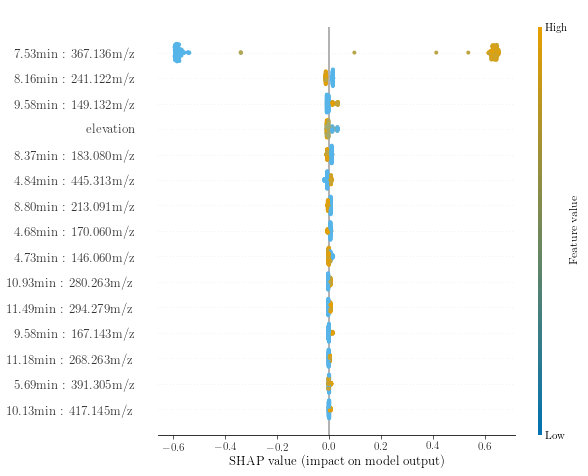

In [13]:
summary_plot(shaps, features, max_display=15, plot_type='dot', show=True, pdf='_NZ')

In [ ]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

#### 100 runs of 5-fold CV
```mean AUC: 0.987888
std AUC: 0.006643
mean accuracy: 0.976495
std accuracy: 0.004496```

### All compounds, except those with fewer than 20 (approx. 10% of data) non-zero values

In [15]:
features20 = pd.read_csv('../data/processed/features_NZ20.csv', index_col='id')

In [16]:
features20.head()

,2.04min : 211.144m/z,2.05min : 428.143m/z,2.05min : 281.114m/z,2.05min : 582.216m/z,2.06min : 748.297m/z,2.06min : 102.054m/z,2.06min : 286.176m/z,2.07min : 391.207m/z,2.07min : 580.704m/z,2.07min : 412.157m/z,...,chaiyaphum,kalasin,kamphaengphet,lampang,mahasarakham,nakhonratchasima,phetchabuns,phitsanulok,saraburi,udonthani
id,,,,,,,,,,,,,,,,,,,,,
97_GB4_01_19789,10.538688,0.0,0.0,0.0,0.0,0.0,0.000000,8.621381,0.0,8.288634,...,0,0,0,0,0,0,0,1,0,0
243_BC2_01_19840,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,10.250869,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
244_BC3_01_19841,0.000000,0.0,0.0,0.0,0.0,0.0,9.124625,10.980353,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
245_BC4_01_19842,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,8.992463,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
246_BC5_01_19844,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,7.888185,...,0,0,0,0,0,0,0,1,0,0


In [17]:
aucs, accs, shaps = crossval(features20, y)

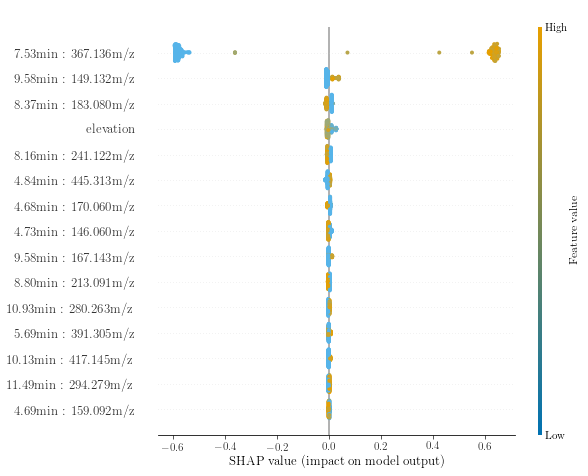

In [18]:
summary_plot(shaps, features20, max_display=15, plot_type='dot', show=True, pdf='_NZ20')

In [ ]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

#### 100 runs of 5-fold CV
```mean AUC: 0.989151
std AUC: 0.006564
mean accuracy: 0.976883
std accuracy: 0.004734```

### After removing clusters w/threshold 0.99

In [20]:
features2099 = pd.read_csv('../data/processed/features_NZ20_099.csv', index_col='id')

In [21]:
features2099.head()

,2.04min : 211.144m/z,2.05min : 428.143m/z,2.05min : 281.114m/z,2.05min : 582.216m/z,2.06min : 748.297m/z,2.06min : 102.054m/z,2.06min : 286.176m/z,2.07min : 391.207m/z,2.07min : 580.704m/z,2.07min : 412.157m/z,...,chaiyaphum,kalasin,kamphaengphet,lampang,mahasarakham,nakhonratchasima,phetchabuns,phitsanulok,saraburi,udonthani
id,,,,,,,,,,,,,,,,,,,,,
97_GB4_01_19789,10.538688,0.0,0.0,0.0,0.0,0.0,0.000000,8.621381,0.0,8.288634,...,0,0,0,0,0,0,0,1,0,0
243_BC2_01_19840,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,10.250869,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
244_BC3_01_19841,0.000000,0.0,0.0,0.0,0.0,0.0,9.124625,10.980353,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
245_BC4_01_19842,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,8.992463,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
246_BC5_01_19844,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,7.888185,...,0,0,0,0,0,0,0,1,0,0


In [22]:
aucs, accs, shaps = crossval(features2099, y)

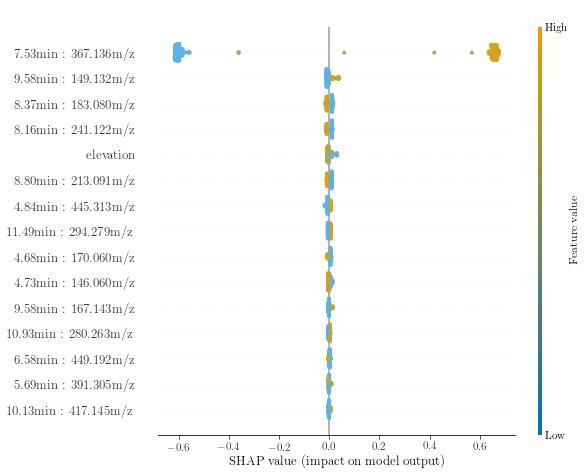

In [23]:
summary_plot(shaps, features2099, max_display=15, plot_type='dot', show=True, pdf='_NZ20_099')

In [ ]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

#### 100 runs of 5-fold CV
```mean AUC: 0.989885
std AUC: 0.005102
mean accuracy: 0.976097
std accuracy: 0.006302```

### After removing clusters w/threshold 0.95

In [25]:
features2095 = pd.read_csv('../data/processed/features_NZ20_095.csv', index_col='id')

In [26]:
features2095.head()

,2.04min : 211.144m/z,2.05min : 428.143m/z,2.05min : 281.114m/z,2.05min : 582.216m/z,2.06min : 748.297m/z,2.06min : 102.054m/z,2.06min : 286.176m/z,2.07min : 391.207m/z,2.07min : 580.704m/z,2.07min : 412.157m/z,...,chaiyaphum,kalasin,kamphaengphet,lampang,mahasarakham,nakhonratchasima,phetchabuns,phitsanulok,saraburi,udonthani
id,,,,,,,,,,,,,,,,,,,,,
97_GB4_01_19789,10.538688,0.0,0.0,0.0,0.0,0.0,0.000000,8.621381,0.0,8.288634,...,0,0,0,0,0,0,0,1,0,0
243_BC2_01_19840,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,10.250869,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
244_BC3_01_19841,0.000000,0.0,0.0,0.0,0.0,0.0,9.124625,10.980353,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
245_BC4_01_19842,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,8.992463,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
246_BC5_01_19844,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,7.888185,...,0,0,0,0,0,0,0,1,0,0


In [27]:
aucs, accs, shaps = crossval(features2095, y)

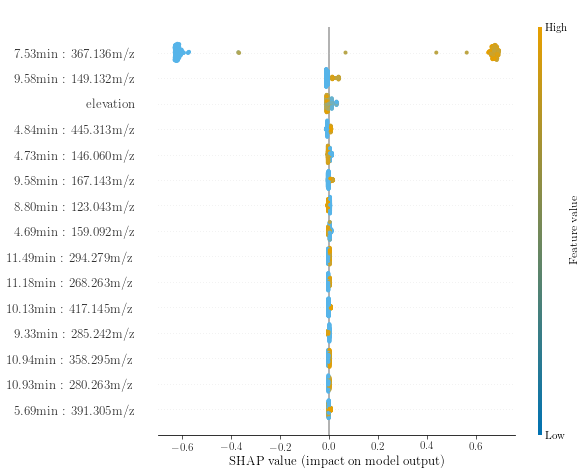

In [28]:
summary_plot(shaps, features2095, max_display=15, plot_type='dot', show=True, pdf='_NZ20_095')

In [ ]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

#### 100 runs of 5-fold CV
```mean AUC: 0.989621
std AUC: 0.007150
mean accuracy: 0.975245
std accuracy: 0.015070```

### After removing clusters w/threshold 0.9

In [30]:
features2090 = pd.read_csv('../data/processed/features_NZ20_090.csv', index_col='id')

In [31]:
features2090.head()

,2.04min : 211.144m/z,2.05min : 428.143m/z,2.05min : 281.114m/z,2.05min : 582.216m/z,2.06min : 748.297m/z,2.06min : 102.054m/z,2.06min : 286.176m/z,2.07min : 391.207m/z,2.07min : 580.704m/z,2.07min : 412.157m/z,...,chaiyaphum,kalasin,kamphaengphet,lampang,mahasarakham,nakhonratchasima,phetchabuns,phitsanulok,saraburi,udonthani
id,,,,,,,,,,,,,,,,,,,,,
97_GB4_01_19789,10.538688,0.0,0.0,0.0,0.0,0.0,0.000000,8.621381,0.0,8.288634,...,0,0,0,0,0,0,0,1,0,0
243_BC2_01_19840,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,10.250869,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
244_BC3_01_19841,0.000000,0.0,0.0,0.0,0.0,0.0,9.124625,10.980353,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
245_BC4_01_19842,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,8.992463,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
246_BC5_01_19844,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,7.888185,...,0,0,0,0,0,0,0,1,0,0


In [32]:
aucs, accs, shaps = crossval(features2090, y)

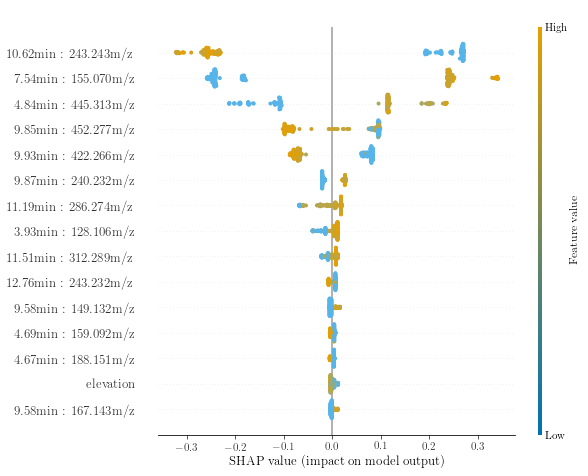

In [33]:
summary_plot(shaps, features2090, max_display=15, plot_type='dot', show=True, pdf='_NZ20_090')

In [ ]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

#### 100 runs of 5-fold CV
```mean AUC: 0.993106
std AUC: 0.003666
mean accuracy: 0.962438
std accuracy: 0.017952```

### Single-feature predictions

Using the 5 most important features from above plus all members of their given clusters.

```['10.62min : 243.243m/z', '7.54min : 155.070m/z', '4.84min : 445.313m/z', '9.85min : 452.277m/z', '9.93min : 422.266m/z']```

In [35]:
N = 5
sorted_feats_idx = np.argsort(np.sum(np.abs(shaps), axis=0)[:-1])[::-1][:N]
sorted_feats = features2090.columns.values[sorted_feats_idx]

In [ ]:
sorted_feats

In [39]:
corr090 = pd.read_csv('../data/processed/corr090.csv', index_col=0)

In [40]:
summary = pd.DataFrame(columns=['feature', 'cluster', 'mean AUC', 'std AUC', 'mean accuracy', 'std accuracy'])
for i, parent in enumerate(sorted_feats):
    if parent not in corr090.index.values:
        cluster = [parent]
    else:
        cluster = searchcluster(parent, corr090, 0.9)
    results = pd.DataFrame({'feature': cluster, 'cluster': (i+1)*np.ones(len(cluster))})
    
    aucmean = []
    aucstd = []
    accmean = []
    accstd = []
    
    for child in cluster:
        aucs, accs, shaps = crossval(features20[child], y)
        aucmean.append(np.mean(aucs))
        aucstd.append(np.std(aucs))
        accmean.append(np.mean(accs))
        accstd.append(np.std(accs))
    
    results['mean AUC'] = aucmean
    results['std AUC'] = aucstd
    results['mean accuracy'] = accmean
    results['std accuracy'] = accstd
    
    summary = pd.concat([summary, results], axis=0)

summary = summary.reset_index().drop(['index'], axis=1)

In [41]:
summary.sort_values(by='mean AUC', ascending=False).head()

,feature,cluster,mean AUC,std AUC,mean accuracy,std accuracy
19,7.53min : 367.136m/z,1.0,0.981003,0.002830,0.974380,0.005017
29,9.85min : 452.277m/z,4.0,0.959256,0.004302,0.900762,0.011212
16,4.68min : 237.831m/z,1.0,0.949240,0.003540,0.942138,0.025590
0,4.68min : 263.203m/z,1.0,0.942861,0.002805,0.929949,0.031504
22,8.80min : 255.138m/z,1.0,0.941307,0.002880,0.937816,0.025330


In [42]:
summary.to_csv('../data/processed/summary.csv', index=False)

### The best predictor, binarised

In [24]:
scaler = Binarizer()

binary = features20['7.53min : 367.136m/z']
binary = pd.DataFrame({'bin': np.reshape(scaler.fit_transform(np.reshape(binary.values, (1,-1))), -1)})

In [28]:
aucs, accs, shaps = crossval(binary.bin, y)

In [ ]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

#### 100 runs of 5-fold CV
```mean AUC: 0.969231
std AUC: 0.001604
mean accuracy: 0.969301
std accuracy: 0.000126```